In [2]:
### Preparing the workbook
import numpy as np
import pandas as pd
import pyfolio as pf
import talib as ta
import matplotlib.pyplot as plt

%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

## 光大技术指标系列（6） － Chaikin AD



In [3]:
### Load Data
### Reading 中证500 ETF（510500）
data = pd.read_csv('../../data/hs300.csv', index_col='date', parse_dates=True)

### weekly resample
#ohlc_dict = {
#    'open':'first',
#    'high':'max',
#    'low':'min',
#    'close':'last',
#    'vol':'sum'
#    }
#data = data.resample('W-Fri', how=ohlc_dict)

#data = data['20020901'::]
#data = data['20120315']
ret = pd.DataFrame()
ret['cc'] = (data['close'] / data['close'].shift(1) - 1)
ret['co'] = (data['close'] / data['open'] - 1)
ret['oc'] = (data['open'] / data['close'].shift(1) - 1)

data['cc'] = ret['cc']
data['co'] = ret['co']

OSError: File b'../../data/hs300.csv' does not exist

In [247]:
### AD/Chaikin Index
def chaikin(data, N = 20, m = 9, n = 13):
    C = data['close']
    H = data['high']
    L = data['low']
    Vol = data['vol']

    A = (C - L) - (H - C)
    B = (H - L)
    C = A / B * Vol

    #AD = pd.rolling_sum(C, N)
    AD = C.cumsum()
    chaikin = pd.rolling_mean(AD, m) - pd.rolling_mean(AD, n)
    return AD, chaikin

In [241]:
talib.AD?

In [248]:
# 测试 － 光大策略
AD, CK = chaikin(data, N=20, m=9, n=13)
signal = pd.DataFrame()
#signal['1'] = ((AD > AD.shift(1)))
#signal['2'] = (AD < AD.shift(1)) 
signal['3'] = (CK > 0)
signal['4'] = (CK < 0)
signal['index'] = 1

#signal['1+2'] = signal['1']*1 - signal['2']*1
signal['3+4'] = signal['3']*1 - signal['4']*1

ret_strategy = signal.shift(1)* data['cc'] 


ret_strategy = ret_strategy.dropna()
#pf.create_full_tear_sheet(ret_strategy['3+4'])

/Applications/anaconda/lib/python3.4/site-packages/pandas/core/frame.py:3200: FutureWarning: TimeSeries broadcasting along DataFrame index by default is deprecated. Please use DataFrame.<op> to explicitly broadcast arithmetic operations along the index
  FutureWarning)


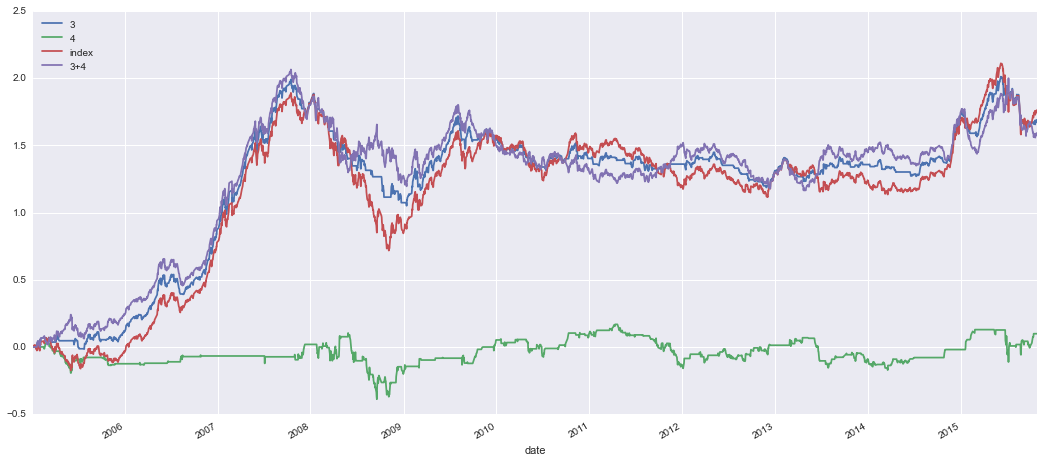

In [249]:
(ret_strategy).cumsum().plot()

In [190]:
### 用Chaikin运行zipline

In [250]:
def Chaikin_Strategy(data, N = 20, m = 14, n = 16) :
    AD, CK = chaikin(data, N, m, n)
    signal_trade = pd.DataFrame()
    signal_trade['long'] = ((CK > 0))*1 ## CK > 0,做多
    signal_trade['short'] = ((CK < 0))*-1 ## CK < 0, 做空
    signal_trade['total'] = signal_trade['long'] + signal_trade['short']
    
    rets = ret['cc'] * signal_trade.shift(1)
    rets = rets.dropna()
    return rets;

/Applications/anaconda/lib/python3.4/site-packages/pandas/core/frame.py:3200: FutureWarning: TimeSeries broadcasting along DataFrame index by default is deprecated. Please use DataFrame.<op> to explicitly broadcast arithmetic operations along the index
  FutureWarning)


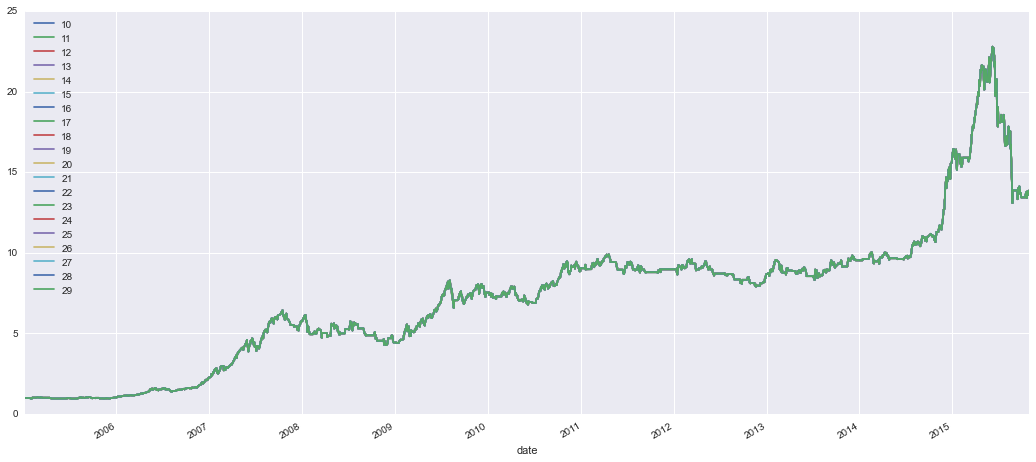

In [252]:
rets_test = pd.DataFrame();
for i in range(10, 30, 1) :
    rets = Chaikin_Strategy(data, N=20, m=14, n = 16)
    rets_test[i] = rets['long']
    
(1+rets_test).cumprod().plot()